# Matrix completion Movie recommender

We will build a personalized movie recommender system. We will use the 100K MovieLens dataset available at https://grouplens.org/datasets/movielens/100k/. There are m = 1682 movies and n = 943 users. Each user rated at least 20 movies, but some watched many more. The total dataset contains 100,000 total ratings from all users. The goal is to recommend movies the users haven’t seen.

Below we train 3 models.
1. We will do a basic predictive model where the movie rating will be the average rating of all users who have rated that movie, and if the movie does not have any users who have rated it the rating will just be set to the average of the entire movie rating set.
2. Next we will do a matrix completion model using SVD. We will train the model for different values of d prinicpal components.
3. Finally, we will do an alternating least squares movie where we optimize the u, v matrices for the uv predictor. The u matrix is size (n,d) and the v matrix is size (m,d). The idea is that the product uv will give a rating for the movie based off of some d features and user tendencies. We attempt to maximize the error based only on the ratings that we actually have not the missing values.

We see that the ALS model works fairly well but it could definitely be improved upon. However it is a relatively simple program and can be trained relatively quickly.

In [1]:
import csv
import numpy as np
data = []
with open('data\\ml-100k\\u.data') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for row in spamreader:
        data.append([int(row[0])-1, int(row[1])-1, int(row[2])])
    
data = np.array(data)
num_observations = len(data) # num_observations = 100,000
num_users = max(data[:,0])+1 # num_users = 943, indexed 0,...,942
num_items = max(data[:,1])+1 # num_items = 1682 indexed 0,...,1681
np.random.seed(1)
num_train = int(0.8*num_observations)

perm = np.random.permutation(data.shape[0])
train = data[perm[0:num_train],:]
test = data[perm[num_train::],:]

In [2]:
import pandas as pd
from typing import Tuple

def basic_prediction(train: np.ndarray,
                      test: np.ndarray) -> Tuple[np.ndarray, float]:
    """ 
    args:
        train: an ndarray with 3 columns, user id, movie id, rating
        test: an ndarray with 3 columns, user id, movie id, rating
    returns:
        a tuple containing the predicted ratings as a NumPy array and the mean squared error as a float
    """
    columns = ['user', 'movie', 'rating']
    train_df = pd.DataFrame(train, columns=columns)
    test_df = pd.DataFrame(test, columns=columns)
    movie_ratings = train_df.groupby('movie')['rating'].mean()
    
    preds = np.zeros(len(test_df))
    
    for i, movie in enumerate(test_df['movie']):
        if movie in movie_ratings.index:
            preds[i] = movie_ratings[movie]
        else:
            preds[i] = movie_ratings.mean()
    
    error = np.square(preds - test_df['rating']).mean()
    
    return preds, error

basic_prediction(train, test)

(array([3.84146341, 3.85964912, 3.39215686, ..., 3.59340659, 4.26116838,
        3.1875    ]),
 1.0532428361498423)

In [3]:
import numpy as np
from scipy.sparse.linalg import svds

def matrix_factorization(train: np.ndarray,
                         test: np.ndarray,
                         d_values: list) -> Tuple[list, list, list, np.ndarray, np.ndarray]:
    """
    args:
        train: an ndarray with 3 columns, user id, movie id, rating
        test: an ndarray with 3 columns, user id, movie id, rating
        d_values: a list of integers representing the different rank values to use in the SVD
    returns:
        a tuple containing the list of d values and the list of predicted ratings as NumPy arrays for each d value
    """
    # Initialize matrix R
    num_users = len(np.unique(data[:, 0]))
    num_movies = len(np.unique(data[:, 1]))
    
    R = np.zeros((num_users, num_movies))
    
    R = np.zeros((num_users, num_movies))
    for i, j, r in train:
        R[i, j] = r
    
    # Compute SVD for different d values
    d_list = []
    r_hats = []
    errors_train = []
    errors_test = []
    for d in d_values:
        u, s, vt = svds(R, k=d)
        S = np.diag(s)
        R_hat = np.dot(np.dot(u, S), vt)
        d_list.append(d)
        r_hats.append(R_hat)
        
        y_train = train[:,2]
        y_test = test[:,2]
        
        train_preds = R_hat[train[:,0],train[:,1]]
        test_preds = R_hat[test[:,0],test[:,1]]
        
        error_train = np.square(y_train - train_preds).mean()
        error_test = np.square(y_test - test_preds).mean()
        
        errors_train.append(error_train)
        errors_test.append(error_test)
        
    return d_list, errors_train, errors_test, np.array(r_hats), R

In [4]:
d_values = [1,2,5,10,20,50]
output = matrix_factorization(train,test,d_values)

Text(0, 0.5, 'Error (MSE)')

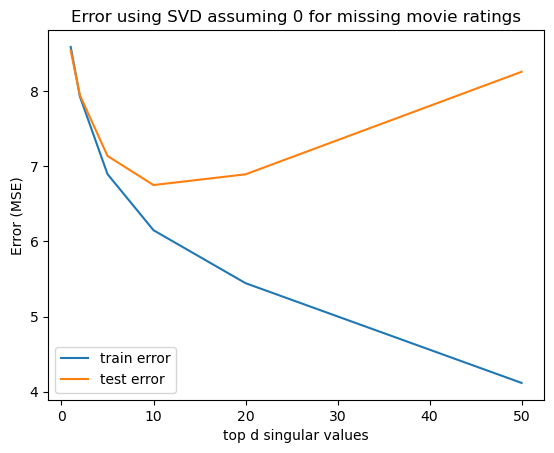

In [5]:
import matplotlib.pyplot as plt

plt.plot(output[0],output[1], label = 'train error')
plt.plot(output[0],output[2], label = 'test error')
plt.legend()
plt.title('Error using SVD assuming 0 for missing movie ratings')
plt.xlabel('top d singular values')
plt.ylabel('Error (MSE)')

In [6]:
def ALS_sparse(train: np.ndarray,
               test: np.ndarray,
               d_values: list,
               lamda: float,
               max_iter=100):
    
    num_users = len(np.unique(data[:, 0]))
    num_movies = len(np.unique(data[:, 1]))
    
    R = np.zeros((num_users, num_movies))
    for i, j, r in train:
        R[i, j] = r
    
    N, M = R.shape
    
    d_list = []
    errors_train = []
    errors_test = []
    
    for d in d_values:    
        u = np.random.randn(N, d) * 3
        v = np.random.randn(M, d) * 3
        
        for _ in range(max_iter):
            # Update u
            for i in range(N):
                j_idx = R[i] > 0 #get the movies each user has rated
                v_j = v[j_idx] #get 1 x movies actually reviewed vector
                R_i = R[i, j_idx] #sparse matrix for user i, has their j movies rated.
                u[i,:] = np.linalg.solve(v_j.T@ v_j + lamda * np.eye(d), v_j.T @ R_i)


            # Update v
            for j in range(M):
                i_idx = R[:, j] > 0
                u_i = u[i_idx]
                R_j = R[i_idx, j]
                v[j,:] = np.linalg.solve(u_i.T@ u_i + lamda * np.eye(d), u_i.T@ R_j)               
        
        R_hat = u@v.T
        
            
        y_train = train[:,2]
        y_test = test[:,2]
        
        train_preds = R_hat[train[:,0],train[:,1]]
        test_preds = R_hat[test[:,0],test[:,1]]
        
        
        
        error_train = np.square(y_train - train_preds).mean()
        error_test = np.square(y_test - test_preds).mean()
        
        errors_train.append(error_train)
        errors_test.append(error_test)
        print("als model error: {:.3}(d = {:}, lambda = {:}, e = {:})".format(error_test,d,lamda,max_iter))
    
    return d_values, errors_train, errors_test, R_hat, R


In [7]:
d_values = [1,2,5,10,20,50]
output = ALS_sparse(train,test,d_values,lamda = 3, max_iter = 50)

als model error: 0.921(d = 1, lambda = 3, e = 50)
als model error: 0.872(d = 2, lambda = 3, e = 50)
als model error: 0.882(d = 5, lambda = 3, e = 50)
als model error: 0.97(d = 10, lambda = 3, e = 50)
als model error: 1.15(d = 20, lambda = 3, e = 50)
als model error: 1.25(d = 50, lambda = 3, e = 50)


Text(0, 0.5, 'Error (MSE)')

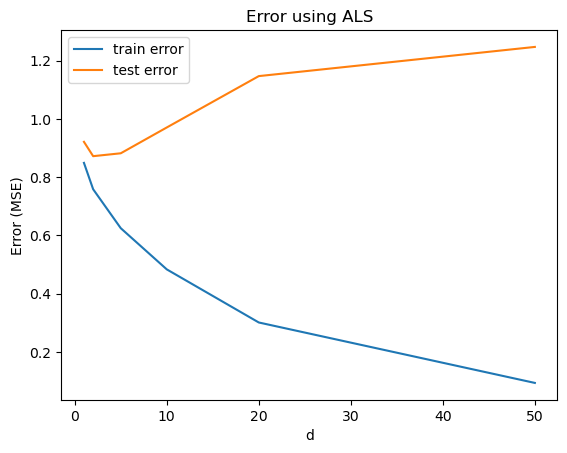

In [8]:
plt.plot(output[0],output[1], label = 'train error')
plt.plot(output[0],output[2], label = 'test error')
plt.legend()
plt.title('Error using ALS')
plt.xlabel('d')
plt.ylabel('Error (MSE)')